# Chapter 6 How to Prepare Time Series Data for CNNs and LSTMs

## 6.2 Time Series to Supervised

In [1]:
from numpy import array
import numpy as np

In [2]:
TS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [3]:
# X, y
# [1, 2, 3], [4]
# [2, 3, 4], [5]
# [3, 4, 5], [6]
# ...

In [4]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

In [5]:
X,y = split_sequence(np.array(TS),3)

In [6]:
np.array(TS)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

- Feature: A column in a dataset, such as a lag observation for a time series dataset.
- Sample: A row in a dataset, such as an input and output sequence for a time series
dataset.

In [7]:
print(X.shape, y.shape)
# show each sample
for i in range(len(X)):
    print(X[i], y[i])

(7, 3) (7,)
[1 2 3] 4
[2 3 4] 5
[3 4 5] 6
[4 5 6] 7
[5 6 7] 8
[6 7 8] 9
[7 8 9] 10


In [8]:
X = X.reshape((X.shape[0], X.shape[1], 1))
print(X.shape)

(7, 3, 1)


## 6.4 Data Preparation Example

In [9]:
# example of defining a dataset
from numpy import array
# define the dataset
data = list()
n = 5000
for i in range(n):
    data.append([i+1, (i+1)*10])
data = array(data)
print(data[:5, :])
print(data.shape)

[[ 1 10]
 [ 2 20]
 [ 3 30]
 [ 4 40]
 [ 5 50]]
(5000, 2)


In [10]:
# drop time
data = data[:, 1]
print(data.shape)

(5000,)


In [11]:
# Split Into Samples
# split into samples (e.g. 5000/200 = 25)
samples = list()
length = 200
# step over the 5,000 in jumps of 200
for i in range(0,n,length):
    # grab from i to i + 200
    sample = data[i:i+length]
    samples.append(sample)
print(len(samples))

25


- The LSTM needs data with the format of **[samples, timesteps, features]**

In [12]:
for i in range(0,n,length):
    # grab from i to i + 200
    sample = data[i:i+length]
    samples.append(sample)
# convert list of arrays into 2d array
data = array(samples)
print(data.shape)

(50, 200)


In [13]:
# reshape into [samples, timesteps, features]
data = data.reshape((len(samples), length, 1))
print(data.shape)

(50, 200, 1)


# Chapter 7 How to Develop MLPs for Time Series Forecasting

## 7.2 Univariate MLP Models

In [14]:
# univariate mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense


# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
             break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps))
yhat = model.predict(x_input, verbose=0)
print(yhat)


[[100.06744]]


## 7.3 Multivariate MLP Models

data where there is more than one observation for each time step.
- 1. Multiple Input Series.
- 2. Multiple Parallel Series.

### 7.3.1 Multiple Input Series

#### 7.3.1.1 MLP Model

In [15]:
# multivariate data preparation
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
             break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print('X shape = [num_samples, num_timesteps, num_variables]')
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])
    
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

X shape = [num_samples, num_timesteps, num_variables]
(7, 3, 2) (7,)
[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185
[[205.3477]]


#### 7.3.1.2 Multi-headed MLP Model

In [16]:
# multivariate mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers.merge import concatenate
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
             break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# separate input data
X1 = X[:, :, 0]
X2 = X[:, :, 1]
# first input model
visible1 = Input(shape=(n_steps,))
dense1 = Dense(100, activation='relu')(visible1)
# second input model
visible2 = Input(shape=(n_steps,))
dense2 = Dense(100, activation='relu')(visible2)
# merge input models
merge = concatenate([dense1, dense2])
output = Dense(1)(merge)
model = Model(inputs=[visible1, visible2], outputs=output) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit([X1, X2], y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x1 = x_input[:, 0].reshape((1, n_steps))
x2 = x_input[:, 1].reshape((1, n_steps))
yhat = model.predict([x1, x2], verbose=0)
print(yhat)


[[205.63025]]


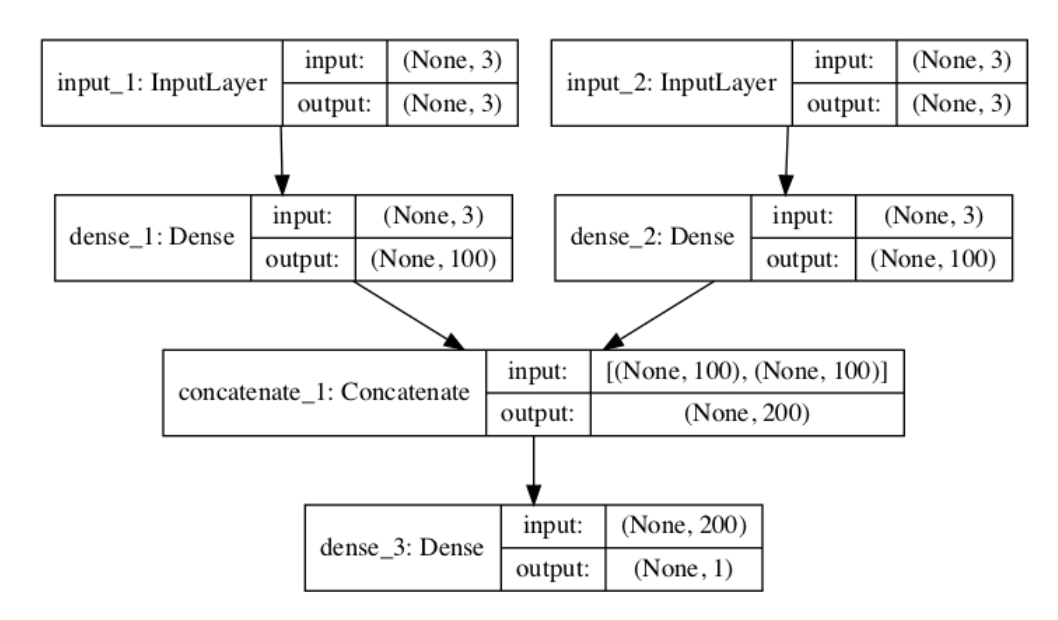

### 7.3.2 Multiple Parallel Series

#### 7.3.2.1 Vector-Output MLP Model

In [21]:
# multivariate output mlp example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))]) # convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
n_output = y.shape[1]
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]
[[100.668724 105.953    207.14581 ]]


#### 7.3.2.2 Multi-output MLP Model

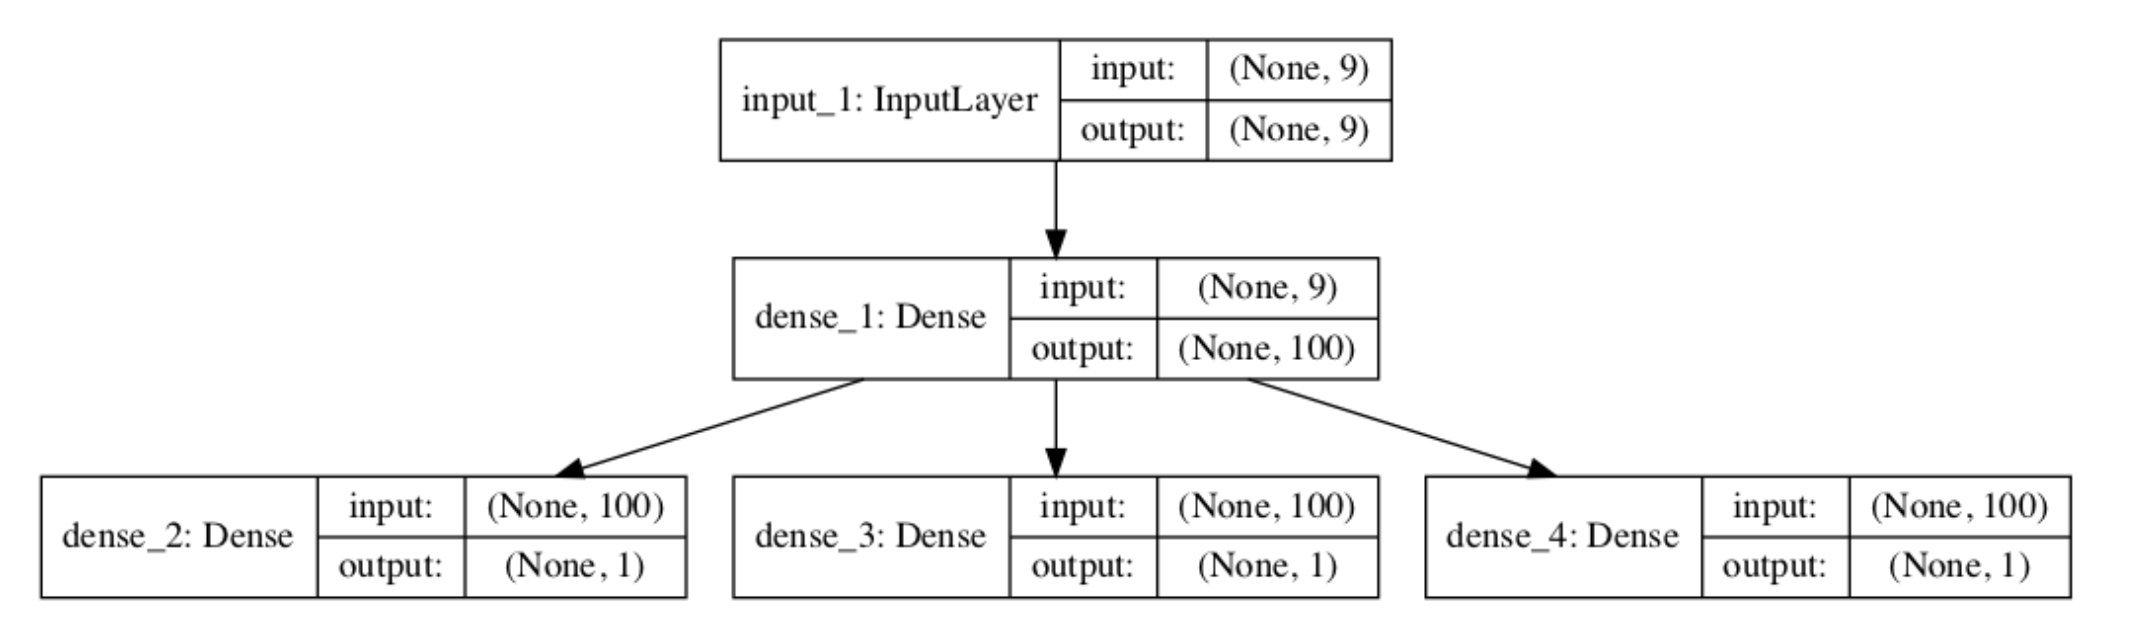

In [23]:
# multivariate output mlp example
from numpy import array
from numpy import hstack
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)

print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])
    
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
# separate output
y1 = y[:, 0].reshape((y.shape[0], 1))
y2 = y[:, 1].reshape((y.shape[0], 1))
y3 = y[:, 2].reshape((y.shape[0], 1))
# define model
visible = Input(shape=(n_input,))
dense = Dense(100, activation='relu')(visible)
# define output 1
output1 = Dense(1)(dense)
# define output 2
output2 = Dense(1)(dense)
# define output 2
output3 = Dense(1)(dense)
# tie together
model = Model(inputs=visible, outputs=[output1, output2, output3]) 
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, [y1,y2,y3], epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]
[array([[100.54883]], dtype=float32), array([[105.91379]], dtype=float32), array([[206.74579]], dtype=float32)]


## 7.4 Multi-step MLP Models


#### 7.4.2 Vector Output Model

In [25]:
# univariate multi-step vector-output mlp example
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the sequence
        if out_end_ix > len(sequence):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])
    

# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_steps_in)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in))
yhat = model.predict(x_input, verbose=0)
print(yhat)

(5, 3) (5, 2)
[10 20 30] [40 50]
[20 30 40] [50 60]
[30 40 50] [60 70]
[40 50 60] [70 80]
[50 60 70] [80 90]
[[101.79203 112.42668]]


## 7.5 Multivariate Multi-step MLP Models

### 7.5.1 Multiple Input Multi-step Output

We may use three prior time steps of each of the two input time series to predict two time steps of the output time series.

In [27]:
# multivariate multi-step mlp example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out-1
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1:out_end_ix, -1]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))]) # convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(n_steps_out))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[70, 75], [80, 85], [90, 95]])
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)


(6, 3, 2) (6, 2)
[[10 15]
 [20 25]
 [30 35]] [65 85]
[[20 25]
 [30 35]
 [40 45]] [ 85 105]
[[30 35]
 [40 45]
 [50 55]] [105 125]
[[40 45]
 [50 55]
 [60 65]] [125 145]
[[50 55]
 [60 65]
 [70 75]] [145 165]
[[60 65]
 [70 75]
 [80 85]] [165 185]
[[185.6967  205.52167]]


### 7.5.2 Multiple Parallel Input and Multi-step Output

In [28]:
# [[ 10 15 25] 
# [ 20 25 45] 
# [ 30 35 65] 
# [ 40 45 85] 
# [ 50 55 105] 
# [ 60 65 125] 
# [ 70 75 145] 
# [ 80 85 165] 
# [ 90 95 185]]

We may use the last three time steps from each of the three time series as input to the model and predict the next time steps of each of the three time series as output. The first sample in the training dataset would be the following.

In [29]:
# Input:
# 10, 15, 25
# 20, 25, 45
# 30, 35, 65
# Output:
# 40, 45, 85
# 50, 55, 105

In [32]:
# multivariate multi-step mlp example
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import Dense
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))]) # convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)

print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])
    
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))
# flatten output
n_output = y.shape[1] * y.shape[2]
y = y.reshape((y.shape[0], n_output))
# define model
model = Sequential()
model.add(Dense(100, activation='relu', input_dim=n_input)) 
model.add(Dense(n_output))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=2000, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]]) 
x_input = x_input.reshape((1, n_input))
yhat = model.predict(x_input, verbose=0)
print(yhat)

(5, 3, 3) (5, 2, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [[ 40  45  85]
 [ 50  55 105]]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [[ 50  55 105]
 [ 60  65 125]]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [[ 60  65 125]
 [ 70  75 145]]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [[ 70  75 145]
 [ 80  85 165]]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [[ 80  85 165]
 [ 90  95 185]]
[[ 90.70774  96.38768 187.61134 101.77631 107.02182 208.87755]]
